# Beam Loading in TW structures

In [1]:
import RF_Track as RFT
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

In [2]:
import scripts

Available in Lattice and Volume </br>
Based on a power diffusive model: 
$$
- \frac{\partial G}{\partial t} = v_g \frac{\partial G}{\partial z} + \left( \frac{\partial v_g}{\partial z} - \frac{v_g}{r/Q}\frac{\partial (r/Q)}{\partial z} + \frac{\omega}{Q} \right)\frac{G}{2} + \frac{\omega \frac{r}{Q}\mathcal{T} I}{2}
$$
where:
- G is the accelerating gradient, defined as $ G = \frac{1}{L} \int_0^L |\tilde{E}_z(z)|\text{d}z$
- $Q$ - Unloaded quality factor.
- $r/Q$ - Normalized shunt impedance per unit length (geometrical)
- $v_g$ Group velocity
- $\mathcal{T}$ is the time-transit factor (for on-crest particles in TW structures, $\mathcal{T} = 1$)
- $\tilde{I} = \frac{q_\text{bunch}F(\omega)}{T_\text{RF}}$, with $T_\text{RF} = \frac{1}{f}$ and $F(\omega)$ the bunch form factor

Further information can be found at: 
- Olivares Herrador J, Latina A, Aksoy A, Fuster Martínez N, Gimeno B and Esperante D(2024). *Implementation of the beam-loading effect in the tracking code RF-track based on a power-diffusive model.* Front. Phys. 12:1348042. doi: 10.3389/fphy.2024.1348042

Required arguments:
- [Option a]: Fieldmap + unloaded Q_factor $Q$ + Group velocity $v_g$
- [Option b]: Normalized shunt impedance per unit length $r/Q$ + unloaded Q_factor $Q$ + Group velocity $v_g$ (Preferred)

## Example: CLIC main accelerating TW structure
### Define TW structure

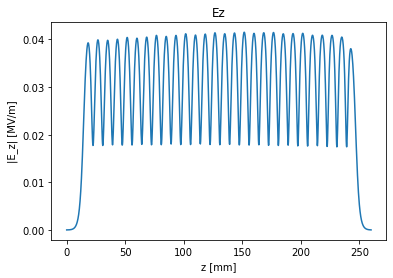

In [3]:
# Import fieldmap from file
T = np.loadtxt('data/efield_Ez.dat')

Ez = T[:,1] + 1j*T[:,2] # V/m, on-axis field
hz = T[1,0] - T[0,0]    # m
N = len(Ez)             # Number of elements in Ez
L = (N - 1) * hz        # Total length in meters

# Generate the z_field array in millimeters
z_field = np.linspace(0, L * 1000, N)

# Frequency in Hz
freq = 11.994 * 1e9

# Plotting
plt.plot(z_field, np.abs(Ez) / 1e6)
plt.xlabel('z [mm]')
plt.ylabel('|E_z| [MV/m]')
plt.title('Ez')
plt.show()

We define the RF_Fieldmap (TWS):

In [4]:
# RF-element
TWS = RFT.RF_FieldMap_1d (Ez, hz, L, freq, 1)
TWS.set_odeint_algorithm('rk2')

True

The given fieldmap has an amplitude of 0.04 MV/m, corresponding to an input power of $P_\text{map}$ = 4W. If we want to scale it to a given power $P_\text{actual}$, we need to set it as follows:

In [5]:
Pmap    = 4 # W - input field map
Pactual = 61.3e6 # W
TWS.set_P_map( Pmap )
TWS.set_P_actual( Pactual )

Now the fieldmap is rescaled according to the factor $\sqrt{\frac{P_\text{actual}}{P_\text{map}}}$. 

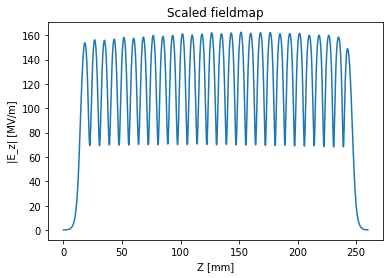

In [6]:
abs_Ez = []

TWS.set_t0(0.0)

for z in z_field:
    # Read the field along the axis
    E, B = TWS.get_field_complex(0, 0, z, 0)
    abs_Ez.append(abs(E[2]))  # Append the magnitude of the z-component of E

TWS.unset_t0()

abs_Ez = np.array(abs_Ez)

# Plot the results
plt.plot(z_field, abs_Ez / 1e6)
plt.xlabel('Z [mm]')
plt.ylabel('|E_z| [MV/m]')
plt.title('Scaled fieldmap')
plt.show()

### Define BL constructor

#### a) Steady BL effect

In [7]:
# Beam-loading required arguments
VG = np.array([1.65, 1.2, 0.83]) / 100  # c
QQ = np.array([5536, 5635, 5738])       # Quality factor
R_Q = np.array([14587, 16220, 17954])   # Ohm/m
phaseadvance = 2 * np.pi / 3            # rad
Ncells = 27                             # Number of cells

# Bunch specification
charge = 600  # pC
population = charge * RFT.pC       # e
Nbunches = 312
fb = freq / 6                           # Hz - Frequency of repetition of the bunches

# A) Steady-state constructor
BL_steady = RFT.BeamLoading (Ncells, freq, phaseadvance, QQ, R_Q, VG, -1, population, fb)

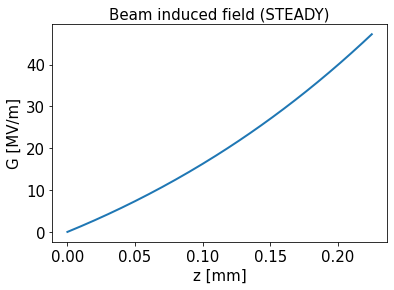

In [8]:
# Retrieve steady-state field and related information
G_steady = BL_steady.get_G_steady() / 1e6  # Convert to MV/m
N = len(G_steady)                          # Number of points
z0 = BL_steady.get_z0()                    # Start position
z1 = BL_steady.get_z1()                    # End position
zplot = np.linspace(z0, z1, N)             # Generate z positions

# Plotting the data
plt.figure(2)
plt.plot(zplot, G_steady, linewidth=2)
plt.xlabel('z [mm]', fontsize=15)
plt.ylabel('G [MV/m]', fontsize=15)
plt.title('Beam induced field (STEADY)', fontsize=15)
plt.gca().tick_params(labelsize=15)  # Set font size for tick labels
plt.show()

#### b) Transient BL effect (uncompensated)

In [9]:
BL = RFT.BeamLoading(Ncells, freq, phaseadvance, QQ, R_Q, VG)

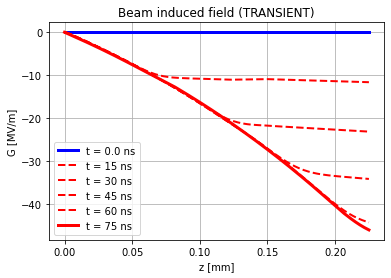

In [10]:
# Solve the transient PDE for trains with equal bunches
BL.solve_pde_transient(-1 * population, fb, Nbunches)

# Retrieve the transient gradient and related data
G = -BL.get_G() / 1e6  # Convert to MV/m
N, M = G.shape         # Dimensions of the transient gradient matrix
Lcell = BL.get_Lcell() * 1000  # Convert to mm
dt = BL.get_dt()               # Time step (mm/c)
last_t = (M - 1) * dt          # Total simulation time (mm/c)
t_transient = np.linspace(0, last_t, M)  # Time axis for the transient data (mm/c)

z0 = BL_steady.get_z0()                    # Start position
z1 = BL_steady.get_z1()                    # End position

# Define times for plotting and corresponding indices
tplot = np.arange(0, 76, 15) * RFT.ns  # Times in mm/c
zplot = np.linspace(z0, z1, N)             # Generate z positions
indices = np.ceil(tplot / dt).astype(int)  # Convert to indices for G

# Plot the unloaded field (first time step)
plt.plot(zplot, G[:, 0], 'b', linewidth=3, label='t = 0.0 ns')  # Unloaded case

# Plot the transient fields at specified times
for idx in indices[1:-1]:  # Skip the first and last times for now
    plt.plot(zplot, G[:, idx], '--r', linewidth=2)

# Plot the final time step
plt.plot(zplot, G[:, -1], 'r', linewidth=3, label=f't = {tplot[-1] / RFT.ns:.1f} ns')

# Add grid, labels, title, and legend
plt.grid(True)
plt.xlabel('z [mm]')
plt.ylabel('G [MV/m]')
plt.title('Beam induced field (TRANSIENT)')
plt.legend([
    't = 0.0 ns',
    't = 15 ns',
    't = 30 ns',
    't = 45 ns',
    't = 60 ns',
    't = 75 ns'
], loc='lower left')

# Show the plot
plt.show()


### Define a bunch

In [11]:
# Define bunch properties
Part = {
    "mass": RFT.electronmass,  # MeV/c^2
    "Q": -1,                        # Charge in units of e
    "P": 90                         # Momentum in MeV (90 MeV)
}
Psigma = 20                         # Momentum spread in permille

# Define Twiss parameters
Twiss = RFT.Bunch6d_twiss()
Twiss.emitt_x = 600/1e6  # Normalized emittance in mm.mrad
Twiss.emitt_y = 10/1e6   # Normalized emittance in mm.mrad
Twiss.beta_x = 10        # Beta function in x (m)
Twiss.beta_y = 10        # Beta function in y (m)
Twiss.sigma_t = 0.045    # Bunch length (mm/c)
Twiss.sigma_pt = Psigma  # Momentum spread

# Create the bunch
Nparticles = 1000
B0 = RFT.Bunch6d( Part["mass"], population, Part["Q"], Part["P"], Twiss, Nparticles)

B0 is the first bunch of the train. The frequency of injection of the bunches is fb. Therefore, each bunch is $1/f_b$ ns appart from each other. The bunch $n$ is injected at a time 
$$
t_\text{inj} = (n-1) \frac{1}{f_b}
$$
</br>
To create a train with Nbunches bunches. We proceed as follows:

In [12]:
# Make a Beam
Nbunches = 100
spacing = RFT.s / fb; # mm/c
B = RFT.Beam(Nbunches, B0, spacing); # Nbunches = 20 for faster computation

### Define Lattice

In [13]:
# Prepare TWS for tracking
TWS.clear_collective_effects()
TWS.add_collective_effect(BL) # Add transient BL to TWS 
TWS.set_cfx_nsteps(10) # At least 1 step per cell

# Prepare a Lattice
L = RFT.Lattice()
L.append(TWS)

### Track and plot

In [14]:
start_time = time.time()
B1 = L.track(B)
end_time = time.time()
print(f"Elapsed time is {end_time - start_time:.2f} seconds")

Elapsed time is 35.42 seconds


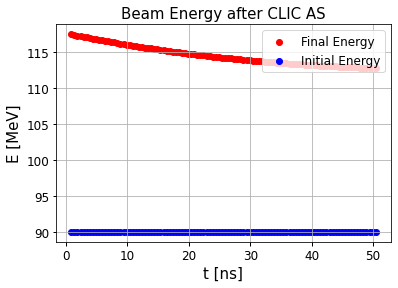

In [15]:
# Initialize the plot
plt.figure()
plt.grid(True)

# Iterate over each bunch and plot energy data
for bunch in range(Nbunches):
    M1 = np.mean(B1[bunch].get_phase_space(), axis=0)  # Final phase space
    M0 = np.mean(B[bunch].get_phase_space(), axis=0)   # Initial phase space

    # Plot final and initial energy
    plt.scatter(M1[4] / RFT.ns, M1[5], color='r', label='Final Energy' if bunch == 0 else "")
    plt.scatter(M1[4] / RFT.ns, M0[5], color='b', label='Initial Energy' if bunch == 0 else "")

# Add title, labels, legend, and formatting
plt.title('Beam Energy after CLIC AS', fontsize=15)
plt.xlabel('t [ns]', fontsize=15)
plt.ylabel('E [MeV]', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.gca().tick_params(labelsize=12, width=1)

# Show the plot
plt.show()
